This notebook walks through a number of different machine learning models to predict the chance of a successful Kickstarter project. Check the readme for the file. Be careful when running the randomized search for the last three models as each took over an hour to run on my machine.

## Part 1: Preparing data

In [1]:
# Import libraries

import numpy as np
import pandas as pd
from scipy import stats # Random number tuning
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read in Kickstarter data

kickstarter = pd.read_csv(r'kickstarter.csv', index_col=0)
kickstarter_vocab = pd.read_csv(r'kickstarter_vocab.csv')

In [3]:
# Selecting model features and response

kickstarter_features = kickstarter[['goal_USD', 'month', 'day', 'year', 'days_to_deadline', 'category_name', 'category_slug', 'location_country']]
kickstarter_response = kickstarter.binary_state

In [4]:
# Changing month, day, and year to categorical data

kickstarter_features.loc[:, 'month'] = kickstarter['month'].astype('category').values
kickstarter_features.loc[:, 'day'] = kickstarter['day'].astype('category').values 
kickstarter_features.loc[:, 'year'] = kickstarter['year'].astype('category').values

C:\Users\Tom\Miniconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
# Encoding category columns

kickstarter_features = pd.get_dummies(kickstarter_features, columns=['category_name', 'category_slug', 'location_country'])

In [6]:
# Binarizing labels into yes/no for successful/failed

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y = lb.fit_transform(kickstarter_response).ravel()

In [7]:
# Log scaling Goal_USD, adding features to model

kickstarter['log_goal_USD'] = kickstarter['goal_USD'].apply(lambda x: np.log1p(x))
kickstarter_features['log_goal_USD'] = kickstarter['log_goal_USD']
kickstarter_features.drop('goal_USD', axis=1, inplace=True)


In [8]:
# Scaling features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(kickstarter_features)

In [9]:
# Minmax scaler for Naive Bayes

def minmaxscaling(X):
    ''' Performs minmaxscaling for Naive Bayes. Returns transformed matrix. '''
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X = scaler.fit_transform(kickstarter_features)
    return (X)

In [10]:
# Splitting data into training and testing. In function to call before naive bayes.

def train_test_split(X, y):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return (X_train, X_test, y_train, y_test)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
# Function to score different machine learning models.

def score_model(clf, X_input_data, y_true):
    '''
    Scores a machine learning model, provides summary statistics, plots ROC curve.
   
    Inputs: classifier, X_input_data (X_train or X_test), y_true (y_train or y_test)
    ''' 
    
    # Scoring models. Test model. Change to allow prediction for X_train
    y_pred = clf.predict(X_input_data)

    # Fit an accuracy score
    from sklearn.metrics import accuracy_score
    print('\n Accuracy Score: \n \n', "{:.2%}".format(accuracy_score(y_true, y_pred, normalize=True)))

    # Create confusion matrix
    from sklearn.metrics import confusion_matrix
    print('\n Confusion Matrix: \n \n', confusion_matrix(y_true, y_pred))

    # Print classification report
    from sklearn.metrics import classification_report
    print('\n Classification Report: \n \n', classification_report(y_true, y_pred))

    # Generate ROC plot
    from sklearn.metrics import roc_curve
    import matplotlib.pyplot as plt

    # Compute predicted probabilities: y_pred_prob. Try except for SGD: hinge loss model.
    try:
        y_pred_prob = clf.predict_proba(X_input_data)[:,1]
        
        # Generate ROC curve values: fpr, tpr, thresholds
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

        # Plot ROC curve
        f, ax = plt.subplots(figsize=(8, 8))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
    
    except AttributeError:
        print('Probability estimates not available \n')
        

## Part 2: Scoring machine learning models without hyperparameter tuning.

### A.) Logistic Regression

Training: 

 Accuracy Score: 
 
 72.91%

 Confusion Matrix: 
 
 [[143118  29353]
 [ 48866  67391]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.75      0.83      0.79    172471
           1       0.70      0.58      0.63    116257

    accuracy                           0.73    288728
   macro avg       0.72      0.70      0.71    288728
weighted avg       0.73      0.73      0.72    288728



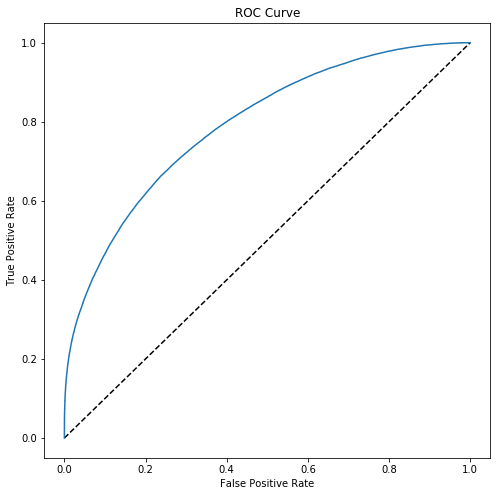

Testing: 

 Accuracy Score: 
 
 72.97%

 Confusion Matrix: 
 
 [[70335 14411]
 [24028 33436]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.75      0.83      0.79     84746
           1       0.70      0.58      0.63     57464

    accuracy                           0.73    142210
   macro avg       0.72      0.71      0.71    142210
weighted avg       0.73      0.73      0.72    142210



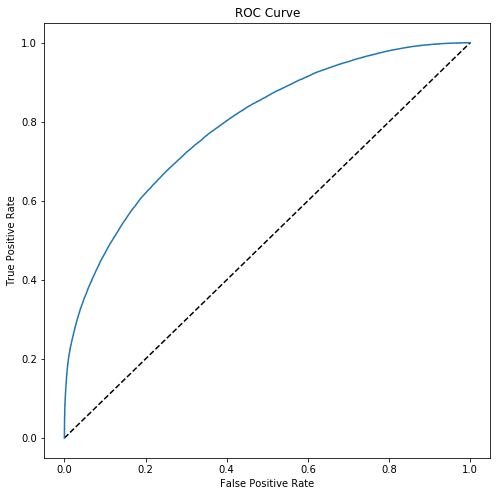

In [12]:
# Working logistic regression out of the box with no hyperparameters.

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs')
fitted = logreg.fit(X_train, y_train)
print('Training: ')
score_model(fitted, X_train, y_train)
print('Testing: ')
score_model(fitted, X_test, y_test)

### B.) Naive Bayes

Training: 

 Accuracy Score: 
 
 70.31%

 Confusion Matrix: 
 
 [[137467  35004]
 [ 50712  65545]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.73      0.80      0.76    172471
           1       0.65      0.56      0.60    116257

    accuracy                           0.70    288728
   macro avg       0.69      0.68      0.68    288728
weighted avg       0.70      0.70      0.70    288728



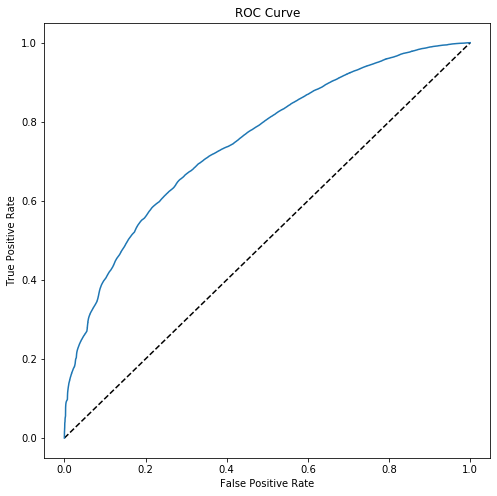

Testing: 

 Accuracy Score: 
 
 70.72%

 Confusion Matrix: 
 
 [[67728 17018]
 [24614 32850]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.73      0.80      0.76     84746
           1       0.66      0.57      0.61     57464

    accuracy                           0.71    142210
   macro avg       0.70      0.69      0.69    142210
weighted avg       0.70      0.71      0.70    142210



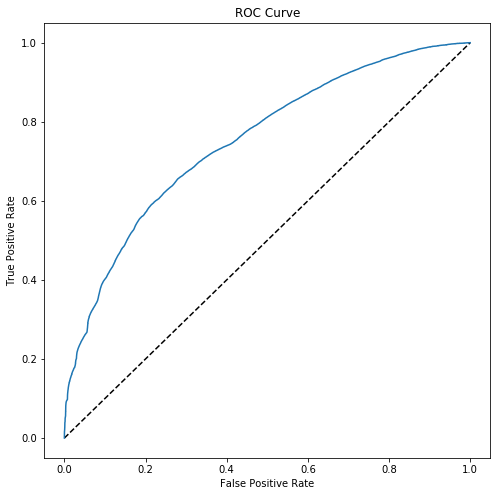

In [13]:
# For Naive Bayes, make sure to run with MinMaxScaler first

from sklearn.naive_bayes import MultinomialNB

X_minmax = minmaxscaling(X)
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_minmax, y)
nb = MultinomialNB()
fitted = nb.fit(X_train_mm, y_train_mm)
print('Training: ')
score_model(fitted, X_train_mm, y_train_mm)
print('Testing: ')
score_model(fitted, X_test_mm, y_test_mm)

### C.) Random Forest

Training: 

 Accuracy Score: 
 
 94.61%

 Confusion Matrix: 
 
 [[166455   6016]
 [  9538 106719]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96    172471
           1       0.95      0.92      0.93    116257

    accuracy                           0.95    288728
   macro avg       0.95      0.94      0.94    288728
weighted avg       0.95      0.95      0.95    288728



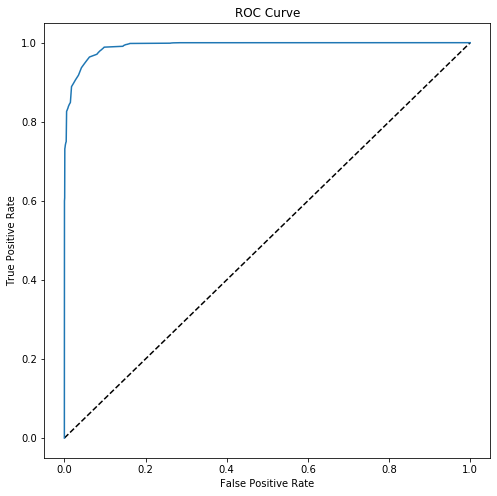

Testing: 

 Accuracy Score: 
 
 74.68%

 Confusion Matrix: 
 
 [[70252 14494]
 [21516 35948]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.77      0.83      0.80     84746
           1       0.71      0.63      0.67     57464

    accuracy                           0.75    142210
   macro avg       0.74      0.73      0.73    142210
weighted avg       0.74      0.75      0.74    142210



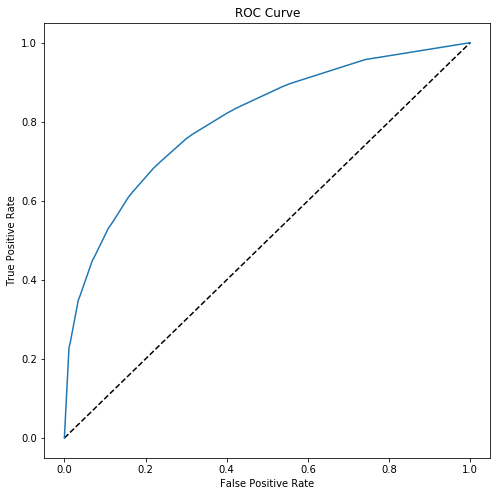

In [14]:
# Fitting random forest model, getting model coefficients

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10)
fitted = rf.fit(X_train, y_train)
print('Training: ')
score_model(fitted, X_train, y_train)
print('Testing: ')
score_model(rf, X_test, y_test)

### D.) Stochastic Gradient Descent

In [15]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
print('Training: ')
fitted = sgd.fit(X_train, y_train)
score_model(fitted, X_train, y_train)
print('Testing: ')
score_model(fitted, X_test, y_test)

Training: 

 Accuracy Score: 
 
 71.14%

 Confusion Matrix: 
 
 [[142797  29674]
 [ 53647  62610]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.73      0.83      0.77    172471
           1       0.68      0.54      0.60    116257

    accuracy                           0.71    288728
   macro avg       0.70      0.68      0.69    288728
weighted avg       0.71      0.71      0.70    288728

Probability estimates not available 

Testing: 

 Accuracy Score: 
 
 71.18%

 Confusion Matrix: 
 
 [[70094 14652]
 [26327 31137]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.73      0.83      0.77     84746
           1       0.68      0.54      0.60     57464

    accuracy                           0.71    142210
   macro avg       0.70      0.68      0.69    142210
weighted avg       0.71      0.71      0.70    142210

Probability estimates not available 



### E.) XGBoost


 Accuracy Score: 
 
 66.88%

 Confusion Matrix: 
 
 [[153860  18611]
 [ 77003  39254]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.67      0.89      0.76    172471
           1       0.68      0.34      0.45    116257

    accuracy                           0.67    288728
   macro avg       0.67      0.61      0.61    288728
weighted avg       0.67      0.67      0.64    288728



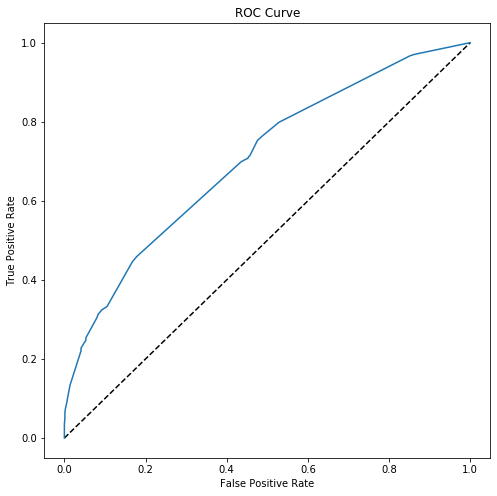


 Accuracy Score: 
 
 67.01%

 Confusion Matrix: 
 
 [[75693  9053]
 [37858 19606]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.67      0.89      0.76     84746
           1       0.68      0.34      0.46     57464

    accuracy                           0.67    142210
   macro avg       0.68      0.62      0.61    142210
weighted avg       0.67      0.67      0.64    142210



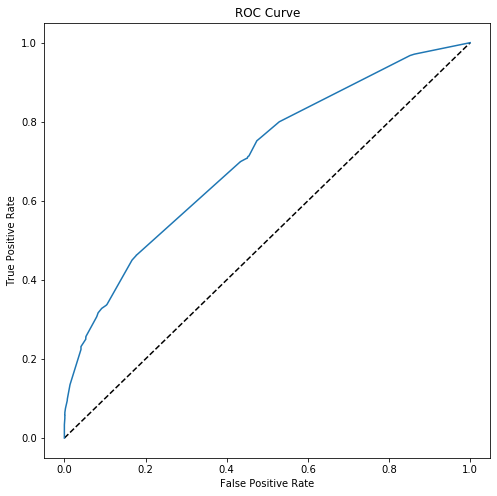

In [16]:
import xgboost as xgb

params = {
    "objective": ['binary:logistic'],
    "eval_metric": ['auc']}
xgb = xgb.XGBRFClassifier(n_estimators=10, parameters=params)
fitted = xgb.fit(X_train, y_train)
score_model(fitted, X_train, y_train)
score_model(fitted, X_test, y_test)


## Part 3: Tuning Hyperparameters 

### A.) Logistic Regression

In [17]:
# Parameters we want to tune: C
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

parameter_list = {'C': stats.uniform(0, 10000)}
logreg = LogisticRegression(solver='lbfgs')
rand_search = RandomizedSearchCV(logreg,
                                 param_distributions=parameter_list,
                                 n_iter=10,
                                 n_jobs=-1,
                                 cv=10,
                                 random_state=42,
                                 scoring='roc_auc')

fitted = rand_search.fit(X_train, y_train)


 Accuracy Score: 
 
 72.91%

 Confusion Matrix: 
 
 [[143118  29353]
 [ 48866  67391]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.75      0.83      0.79    172471
           1       0.70      0.58      0.63    116257

    accuracy                           0.73    288728
   macro avg       0.72      0.70      0.71    288728
weighted avg       0.73      0.73      0.72    288728



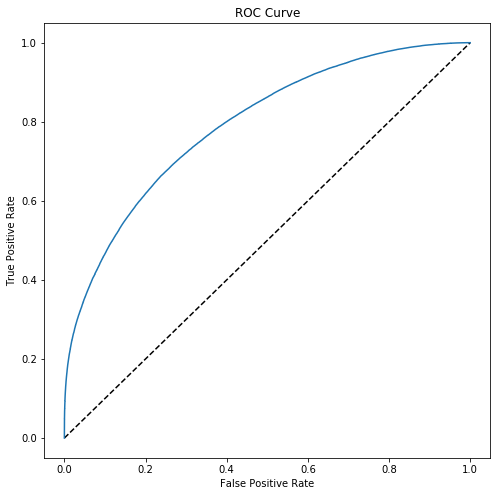


 Accuracy Score: 
 
 72.97%

 Confusion Matrix: 
 
 [[70335 14411]
 [24029 33435]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.75      0.83      0.79     84746
           1       0.70      0.58      0.63     57464

    accuracy                           0.73    142210
   macro avg       0.72      0.71      0.71    142210
weighted avg       0.73      0.73      0.72    142210



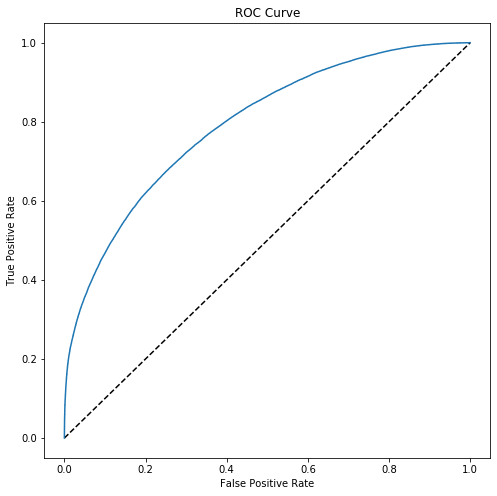

In [18]:
score_model(fitted, X_train, y_train)
score_model(fitted, X_test, y_test)

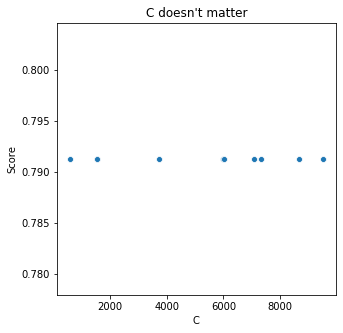

In [19]:
df = pd.DataFrame(rand_search.cv_results_['mean_test_score'],
                  rand_search.cv_results_['param_C'],
                  ).reset_index()
df.columns = ['C', 'Score']
f, ax = plt.subplots(figsize=(5, 5))
ax.set_title("C doesn't matter")
sns.scatterplot(x=df.C, y=df.Score)
plt.show()

### B.) Naive Bayes

In [20]:
# No hyperparameter tuning needed!

### C.) Random Forest


 Accuracy Score: 
 
 68.53%

 Confusion Matrix: 
 
 [[147079  25392]
 [ 65466  50791]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.69      0.85      0.76    172471
           1       0.67      0.44      0.53    116257

    accuracy                           0.69    288728
   macro avg       0.68      0.64      0.65    288728
weighted avg       0.68      0.69      0.67    288728



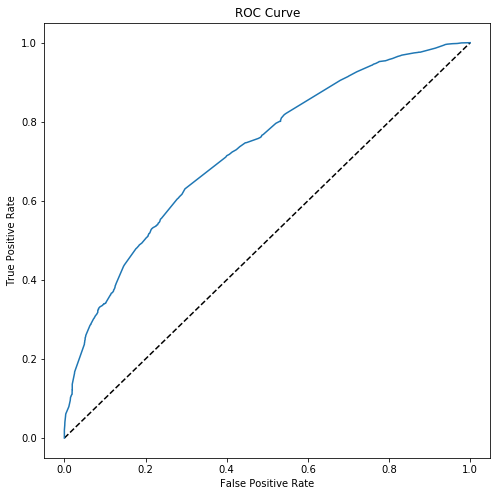


 Accuracy Score: 
 
 68.63%

 Confusion Matrix: 
 
 [[72355 12391]
 [32226 25238]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.69      0.85      0.76     84746
           1       0.67      0.44      0.53     57464

    accuracy                           0.69    142210
   macro avg       0.68      0.65      0.65    142210
weighted avg       0.68      0.69      0.67    142210



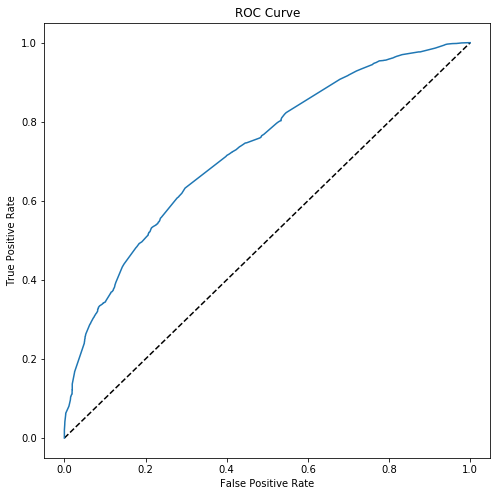

{'n_estimators': 60, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_leaf_nodes': 9, 'max_features': 0.6, 'max_depth': 7}


In [21]:
parameters = {
    'n_estimators': [x for x in range(30, 80, 10)],
    'max_depth': [x for x in range(2, 9)],
    'min_samples_split': [x for x in range(2, 10)],
    'min_samples_leaf': [x for x in range(1, 7)],
    'max_leaf_nodes': [x for x in range(3, 10)],
    'max_features': [x/10 for x in range(1, 10)]
}

from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, param_distributions=parameters, n_iter=25, n_jobs=-1, cv=3)
fitted = rand_search.fit(X_train, y_train)
score_model(fitted, X_train, y_train)
score_model(fitted, X_test, y_test)
print(rand_search.best_params_)


 Accuracy Score: 
 
 95.68%

 Confusion Matrix: 
 
 [[167412   5059]
 [  7408 108849]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.96      0.97      0.96    172471
           1       0.96      0.94      0.95    116257

    accuracy                           0.96    288728
   macro avg       0.96      0.95      0.95    288728
weighted avg       0.96      0.96      0.96    288728



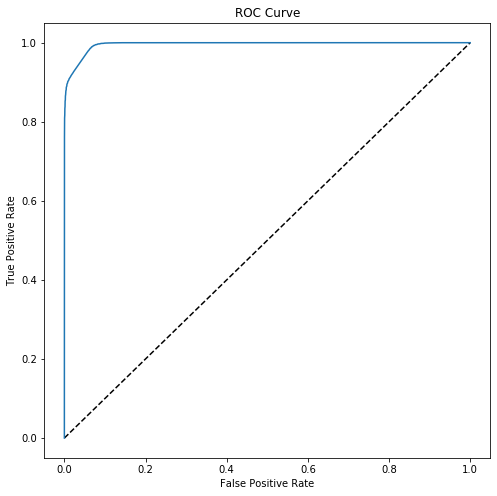


 Accuracy Score: 
 
 75.52%

 Confusion Matrix: 
 
 [[69910 14836]
 [19982 37482]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.78      0.82      0.80     84746
           1       0.72      0.65      0.68     57464

    accuracy                           0.76    142210
   macro avg       0.75      0.74      0.74    142210
weighted avg       0.75      0.76      0.75    142210



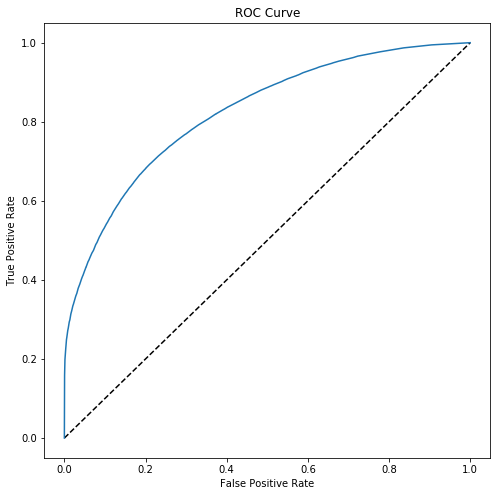

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, 
                            min_samples_leaf=1,  
                            max_features=.2,
                            n_jobs=-1)
fitted = rf.fit(X_train, y_train)
score_model(fitted, X_train, y_train)
score_model(fitted, X_test, y_test)

In [23]:
results = pd.DataFrame(list(kickstarter_features), rf.feature_importances_).reset_index()
results.columns = ['Importance', 'Feature']
top10features = results.sort_values(by='Importance', ascending=False).head(10)

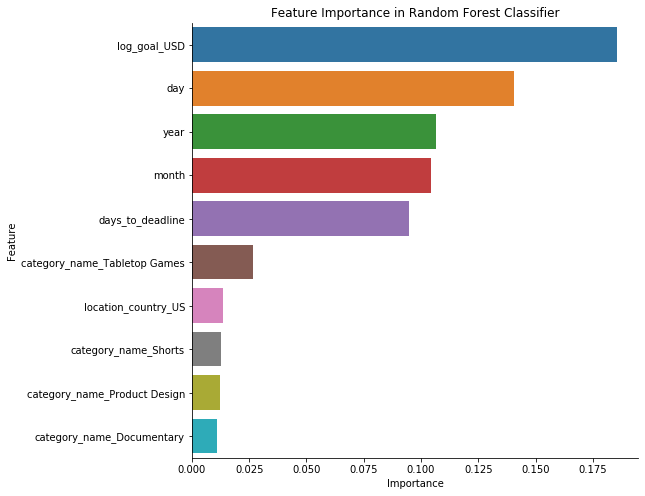

In [24]:
# https://stats.stackexchange.com/questions/314567/feature-importance-with-dummy-variables
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=top10features.Importance, y=top10features.Feature)
ax.set_title("Feature Importance in Random Forest Classifier")
sns.despine()
plt.show()

### D.) Stochastic Gradient Descent


 Accuracy Score: 
 
 72.91%

 Confusion Matrix: 
 
 [[143115  29356]
 [ 48869  67388]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.75      0.83      0.79    172471
           1       0.70      0.58      0.63    116257

    accuracy                           0.73    288728
   macro avg       0.72      0.70      0.71    288728
weighted avg       0.73      0.73      0.72    288728



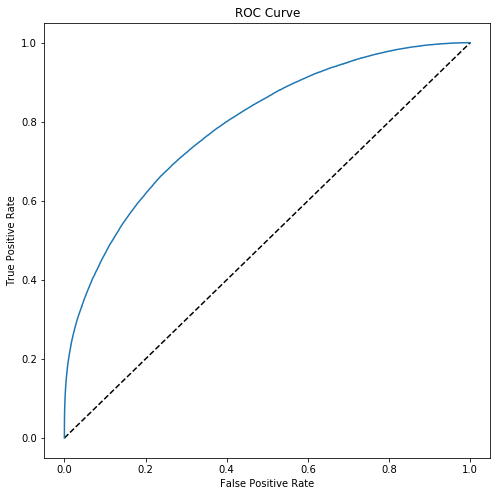


 Accuracy Score: 
 
 72.97%

 Confusion Matrix: 
 
 [[70340 14406]
 [24029 33435]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.75      0.83      0.79     84746
           1       0.70      0.58      0.64     57464

    accuracy                           0.73    142210
   macro avg       0.72      0.71      0.71    142210
weighted avg       0.73      0.73      0.72    142210



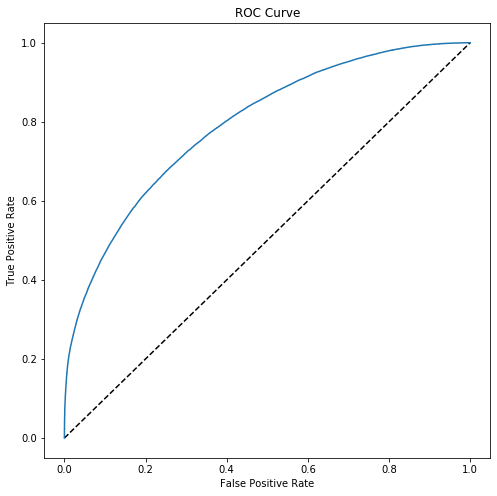

{'penalty': 'l2', 'loss': 'log', 'learning_rate': 'adaptive', 'eta0': 4}


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
parameters = {'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
              'penalty': ['None', 'l1', 'l2', 'elasticnet'],
             'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
             'eta0': [x for x in range(1, 11)]}

rand_search = RandomizedSearchCV(sgd, param_distributions=parameters, n_iter=25, n_jobs=-1, cv=5, scoring='roc_auc')
fitted = rand_search.fit(X_train, y_train)
score_model(fitted, X_train, y_train)
score_model(fitted, X_test, y_test)
print(rand_search.best_params_)

### E.) XGBoost


 Accuracy Score: 
 
 60.43%

 Confusion Matrix: 
 
 [[172432     39]
 [114221   2036]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.60      1.00      0.75    172471
           1       0.98      0.02      0.03    116257

    accuracy                           0.60    288728
   macro avg       0.79      0.51      0.39    288728
weighted avg       0.75      0.60      0.46    288728



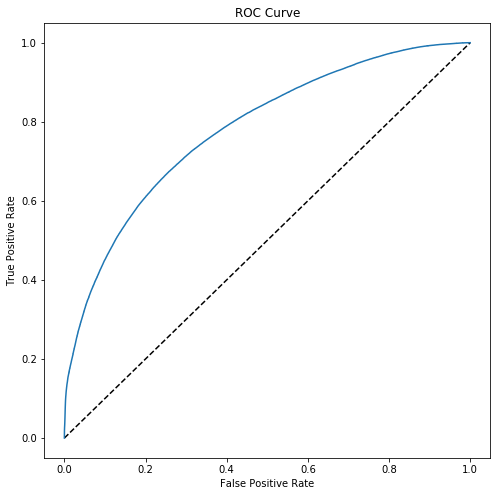


 Accuracy Score: 
 
 60.26%

 Confusion Matrix: 
 
 [[84722    24]
 [56491   973]]

 Classification Report: 
 
               precision    recall  f1-score   support

           0       0.60      1.00      0.75     84746
           1       0.98      0.02      0.03     57464

    accuracy                           0.60    142210
   macro avg       0.79      0.51      0.39    142210
weighted avg       0.75      0.60      0.46    142210



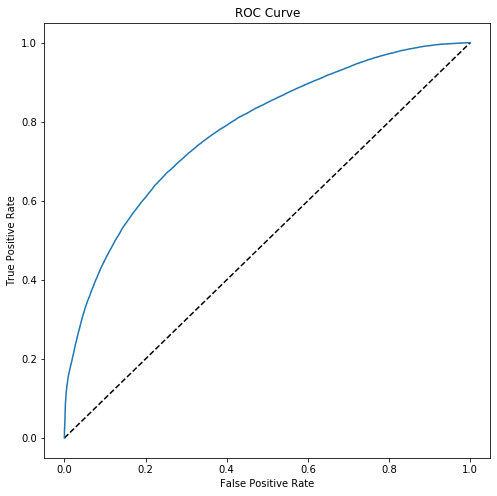

{'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.4, 'gamma': 0.4, 'colsample_bytree': 0.1}


In [26]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

xgb = xgb.XGBRFClassifier()
parameters = {
    "learning_rate": [.1, .2, .3, .4, .5],
    "max_depth": [x for x in range(3, 11)],
    "colsample_bytree": [x/10 for x in range(1, 10)],
    "gamma": [x/10 for x in range(0, 6)],
    "min_child_weight": [x for x in range(1, 4)]
}
rand_search = RandomizedSearchCV(xgb, param_distributions=parameters, n_iter=10, n_jobs=-1, cv=5, scoring='roc_auc')
fitted = rand_search.fit(X_train, y_train)
score_model(fitted, X_train, y_train)
score_model(fitted, X_test, y_test)
print(rand_search.best_params_)

## Part 4: Final Interpretations

In [27]:
# Import VotingClassifier from sklearn.ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Fitting the best models found during hyperparameter tuning.
logreg = LogisticRegression(solver='lbfgs')
nb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=2, max_features=.15, n_jobs=-1)
sgd = SGDClassifier(penalty=None, loss='log', learning_rate='adaptive', eta0=3)
xgb = xgb

# Create list of classifiers
classifiers = [('Logistic Regression', logreg), ('Naive Bayes', nb), ('Random Forest', rf), ('XGBoost', xgb),
               ('SGDClassifier', sgd)]

# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers, voting='soft')

# Fit vc to the training set
vc.fit(X_train_mm, y_train_mm)

# Evaluate the test set predictions
y_pred = vc.predict(X_test_mm)

# Calculate accuracy score
accuracy = accuracy_score(y_pred, y_test)
print('Voting Classifier: {:.2%}'.format(accuracy))

C:\Users\Tom\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Voting Classifier: 73.98%
